## libs

In [50]:
import pandas as pd
import numpy as np
from pathlib import Path

In [51]:
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

In [52]:
import matplotlib.pyplot as plt
from tqdm import tqdm

## initialization

In [53]:
STARS_DIRECTORY = Path('../clusters_mem/')
ISOCHRONES_DIRECTORY = Path ('../isochrones/')
PLOTS_DIRECTORY = Path ('../plots/')
MAIN_DIRECTORY = Path('../')

In [54]:
def get_stars_with_mass(table, name):
    """create df with the value needed (name= 'G' or 'BP-RP') for different q"""
    
    main_component = pd.DataFrame(columns=table.columns, index=[0])
    
    for M_1 in table.columns:
        stars = pd.DataFrame(data={'q' : table.index})
        stars['M_2'] = float(M_1) * stars['q']
        
        stars['G_2, mag'] = interp(isochrone['Mini'], isochrone['Gmag'], stars['M_2'])
        stars['BP_2, mag'] = interp(isochrone['Mini'], isochrone["G_BPmag"], stars['M_2']) 
        stars['RP_2, mag'] = interp(isochrone['Mini'], isochrone["G_RPmag"], stars['M_2'])

        G_1 = interp(isochrone['Mini'], isochrone['Gmag'], M_1)
        BP_1 = interp(isochrone['Mini'], isochrone["G_BPmag"], M_1) 
        RP_1 = interp(isochrone['Mini'], isochrone["G_RPmag"], M_1)

        stars['G, mag'] = stars['G_2, mag'] - 2.5 * np.log10(1 + pow(2.512, stars['G_2, mag'] - G_1))
        stars['BP-RP, mag'] = (stars['BP_2, mag'] - 2.5 * np.log10(1 + pow(2.512, stars['BP_2, mag'] - BP_1)) -
                              (stars['RP_2, mag'] - 2.5 * np.log10(1 + pow(2.512, stars['RP_2, mag'] - RP_1))))


        if name == 'G':
            table[M_1] = stars['G, mag'].tolist()
            main_component[M_1] = G_1

        elif name == 'BP-RP':
            table[M_1] = stars['BP-RP, mag'].tolist()
            main_component[M_1]= BP_1 - RP_1
        else:
            raise ValueError('wrong name') 

    table = main_component.append(table, ignore_index=False)
    return table


def read_file(filename):
    """read file"""
    df = pd.read_csv(filename, delimiter='\\s+')
    df = df.apply(pd.to_numeric, errors='coerce')
    try:
        df.dropna(subset = ['phot_g_mean_mag','bp_rp'], inplace = True)
    except:
        pass
    return df

def interp (a, b, c): 
    """get mass of starS with definite magnitude"""
    func = interp1d(a, b)
    return func(c)

def from_absolute(value, mag_type, cluster):
    """transform absolute to visible magnitude and color index ('G' or 'BP-RP')"""
    if mag_type == 'G':
        return value - 5 + 5 * np.log10(cluster.loc['Distance']) + 2.749632 * (cluster.loc['E(B-V)'])
    elif mag_type == 'BP-RP':
        return value + 1.33104 * cluster.loc['E(B-V)']
    else:
        raise ValueError("mag_type can be only 'G' or 'BP-RP'")

In [74]:
CLUSTER = 'NGC_2516'

In [75]:
clusters_list = pd.read_excel(MAIN_DIRECTORY / 'cluster_list_data.xlsx', index_col = 0)

In [76]:
all_stars = pd.read_hdf(STARS_DIRECTORY / f'{CLUSTER}.h5')
isochrone = read_file(ISOCHRONES_DIRECTORY / f"{CLUSTER}_{clusters_list.loc[CLUSTER,'Age']}.txt")
isochrone = isochrone[isochrone['G_BPmag'] - isochrone['G_RPmag'] > 0]

## cutting off stars in the interval

In [79]:
mask_probability = (all_stars['P_tot'] > 0)

stars = all_stars[mask_probability].copy()
stars['bp-rp'] = stars['phot_bp_mean_mag'] - stars['phot_rp_mean_mag']

In [80]:
# in case high age
mask_turnoff = ((stars['phot_g_mean_mag'] > 8))
stars = stars[mask_turnoff]

In [81]:
mask_color = ((stars['bp-rp'] > from_absolute(0.13, 'BP-RP', clusters_list.loc[CLUSTER, :])) & 
         (stars['bp-rp'] < from_absolute(0.33, 'BP-RP', clusters_list.loc[CLUSTER, :])))
# mask_color = ((stars['BP_RP'] > 0.13) & (stars['BP_RP'] < 0.33))
stars = stars[mask_color]

In [82]:
stars.reset_index(inplace=True)

## qM coordinates grid

In [83]:
q_array = np.sort(abs(np.geomspace(0.1, 1, 50) - 1.1))
M_array = np.geomspace(0.91, 2, 200)

g_table = pd.DataFrame(columns = M_array, index=q_array)
color_table = pd.DataFrame(columns = M_array, index=q_array)

In [84]:
g_table = get_stars_with_mass(g_table, 'G')
color_table = get_stars_with_mass(color_table, 'BP-RP')

In [85]:
g_table = from_absolute(g_table, 'G', clusters_list.loc[CLUSTER, :])
color_table = from_absolute(color_table, 'BP-RP', clusters_list.loc[CLUSTER, :])

## new coordinates definition

In [86]:
M_1 = np.ndarray((len(stars)))
q = np.ndarray((len(stars)))

In [87]:
for i in tqdm(range(len(stars))):
    g = stars.loc[i,'phot_g_mean_mag']
    color = stars.loc[i,'bp-rp']

    g_difference = (g_table - g) * (g_table - g)
    color_difference = (color_table - color) * (color_table - color)
    
    distance = g_difference + color_difference
    M_1[i] = distance.min().idxmin()
    q[i] = distance[M_1[i]].idxmin()

100%|██████████| 25/25 [00:00<00:00, 185.36it/s]


In [88]:
stars['M_1_detected'] = M_1
stars['q_detected'] = q
stars['M_2_detected'] = M_1 * q

In [89]:
plt.rcParams.update({'font.size': 12})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage[utf8]{inputenc}')
plt.rc('text.latex', preamble=r'\usepackage[russian]{babel}')

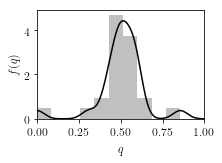

In [90]:
fig, ax = plt.subplots(figsize=(3,2))
stars['q_detected'].plot.kde(bw_method=0.3, c='black')
stars['q_detected'].plot.hist(5, color='#C0C0C0', density=True)
ax.set_xlim(0,1)
ax.set_xlabel('$q$')
ax.set_ylabel('$f(q)$')
plt.savefig(PLOTS_DIRECTORY / (f"q_dist_{CLUSTER}.pdf"), bbox_inches = 'tight')

## from qM to magnitudes transition

In [44]:
stars['G1_after'] = interp(isochrone['Mini'], isochrone['Gmag'], stars['M_1_detected'])
stars['BP1_after'] = interp(isochrone['Mini'], isochrone["G_BPmag"], stars['M_1_detected']) 
stars['RP1_after'] = interp(isochrone['Mini'], isochrone["G_RPmag"], stars['M_1_detected'])

stars['G2_after'] = 0
stars['BP2_after'] = 0
stars['RP2_after'] = 0 

mask = (stars['q_detected'] > 0)
stars.loc[stars[mask].index,'G2_after'] = interp(isochrone['Mini'], isochrone['Gmag'],
                                                 stars.loc[stars[mask].index,'M_2_detected'])
stars.loc[stars[mask].index,'BP2_after'] = interp(isochrone['Mini'], isochrone['G_BPmag'],
                                                 stars.loc[stars[mask].index,'M_2_detected'])
stars.loc[stars[mask].index,'RP2_after'] = interp(isochrone['Mini'], isochrone['G_RPmag'],
                                                 stars.loc[stars[mask].index,'M_2_detected'])

In [45]:
stars['G_after'] = stars['G1_after'] - 2.5 * np.log10(1+ pow(2.512, stars['G1_after'] - stars['G2_after']))
stars['BP-RP_after'] = (stars['BP1_after'] -
                          2.5 *np.log10(1 + pow(2.512, stars['BP1_after'] - stars['BP2_after'])) -
                          (stars['RP1_after'] - 2.5 *np.log10(1+ pow(2.512, stars['RP1_after'] - 
                           stars['RP2_after']))))

mask_singles = (stars['q_detected'] == 0)
stars.loc[stars[mask_singles].index,'G_after']  = stars.loc[stars[mask_singles].index,'G1_after']
stars.loc[stars[mask_singles].index,'BP-RP_after']  = (stars.loc[stars[mask_singles].index,'BP1_after'] -
                                                       stars.loc[stars[mask_singles].index,'RP1_after'])

## estimation of binaries number

In [46]:
sum(stars['q_detected']>=0.3) / (len(stars))

0.96

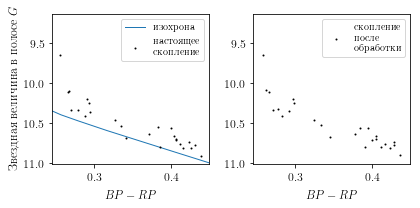

In [47]:
fig, ax = plt.subplots(figsize=(6,3))

plt.subplot(1, 2, 1)
plt.scatter (stars['bp-rp'],
            stars['phot_g_mean_mag'],
            c='black', s=1, zorder=100, label='настоящее \n скопление')

plt.plot(from_absolute(isochrone['G_BPmag'] - isochrone['G_RPmag'], 'BP-RP', clusters_list.loc[CLUSTER]), 
         from_absolute(isochrone['Gmag'], 'G', clusters_list.loc[CLUSTER]), lw=1, label='изохрона')

plt.xlim(stars['bp-rp'].min() - 0.01, stars['bp-rp'].max() + 0.01)
plt.ylim(stars['phot_g_mean_mag'].min() - 0.5, stars['phot_g_mean_mag'].max() + 0.1)
plt.gca().invert_yaxis()
plt.legend(loc='upper right', fontsize='small')
plt.xlabel('$BP-RP$')
plt.ylabel('Звездная величина в полосе $G$')

plt.subplot(1, 2, 2)
plt.scatter (from_absolute(stars['BP-RP_after'], 'BP-RP', clusters_list.loc[CLUSTER]),
             from_absolute(stars['G_after'], 'G', clusters_list.loc[CLUSTER]),
             c='black', s=1, zorder=100, label="скопление \n после \n обработки")
plt.xlim(stars['bp-rp'].min() - 0.01, stars['bp-rp'].max() + 0.01)
plt.ylim(stars['phot_g_mean_mag'].min() - 0.5, stars['phot_g_mean_mag'].max() + 0.1)

plt.legend(loc='upper right', fontsize='small')
plt.gca().invert_yaxis()
plt.xlabel('$BP-RP$')


ax.grid(c='#aaaaaa', ls='--')

ax.tick_params(axis='both', which='major')

fig.tight_layout(h_pad=2.0)

plt.savefig(PLOTS_DIRECTORY / (f"CMD_{CLUSTER}_before_after_qM.pdf"), bbox_inches = 'tight')